<a href="https://colab.research.google.com/github/Git-Hub-Pro/Kalmanfilter/blob/master/pose_orientation_fusion_ekf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/gdrive/')

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import inv
from scipy import io

In [0]:
input_gyro_mat = io.loadmat('/content/gdrive/My Drive/data/kalmanfilter/source/11.ARS/ArsGyro.mat')
input_accel_mat = io.loadmat('/content/gdrive/My Drive/data/kalmanfilter/source/11.ARS/ArsAccel.mat')

In [0]:
def get_gyro(i):
    """Measure angular velocity using gyro."""
    p = input_gyro_mat['wx'][i][0]  # input_mat['wx']: (41500, 1)
    q = input_gyro_mat['wy'][i][0]  # input_mat['wy']: (41500, 1)
    r = input_gyro_mat['wz'][i][0]  # input_mat['wz']: (41500, 1)
    return p, q, r

In [0]:
def get_accel(i):
    """Measure angular acceleration using accelerometer (G-meter)."""
    ax = input_accel_mat['fx'][i][0]  # input_mat['fx']: (41500, 1)
    ay = input_accel_mat['fy'][i][0]  # input_mat['fy']: (41500, 1)
    az = input_accel_mat['fz'][i][0]  # input_mat['fz']: (41500, 1)
    return ax, ay, az

In [0]:
def accel2euler(ax, ay, az, phi, the, psi):
    """Calculate Euler angle (Pose Orientation)."""
    g = 9.8  # 9.8 [m/s^2]
    cosThe = np.cos(the)
    phi = np.arcsin(-ay / (g * cosThe))
    the = np.arcsin(ax / g)
    psi = psi
    return phi, the, psi

In [0]:
def Ajacob_at(x_esti):
    phi, the, psi = x_esti

    sinPhi = np.sin(phi)
    cosPhi = np.cos(phi)
    tanThe = np.tan(the)
    secThe = 1. / np.cos(the)

    A = np.zeros((3, 3))

    A[0][0] = q*cosPhi*tanThe - r*sinPhi*tanThe
    A[0][1] = q*sinPhi*secThe**2 + r*cosPhi*secThe**2
    A[0][2] = 0

    A[1][0] = -q*sinPhi - r*cosPhi
    A[1][1] = 0
    A[1][2] = 0

    A[2][0] = q*cosPhi*secThe - r*sinPhi*secThe
    A[2][1] = q*sinPhi*secThe*tanThe + r*cosPhi*secThe*tanThe
    A[2][2] = 0

    A = np.eye(3) + A * dt
    return A

def Hjacob_at(x_pred):
    return H

In [0]:
def fx(x_esti):
    phi, the, psi = x_esti

    sinPhi = np.sin(phi)
    cosPhi = np.cos(phi)
    tanThe = np.tan(the)
    secThe = 1. / np.cos(the)

    xdot = np.zeros(3)
    xdot[0] = p + q*sinPhi*tanThe + r*cosPhi*tanThe
    xdot[1] = q*cosPhi - r*sinPhi
    xdot[2] = q*sinPhi*secThe + r*cosPhi*secThe

    x_pred = x_esti + xdot*dt
    return x_pred

def hx(x_pred):
    return H @ x_pred

In [0]:
def extended_kalman_filter(z_meas, x_esti, P):
    """Extended Kalman Filter Algorithm."""
    # (1) Prediction.
    A = Ajacob_at(x_esti)
    x_pred = fx(x_esti)
    P_pred = A @ P @ A.T + Q

    # (2) Kalman Gain.
    H = Hjacob_at(x_pred)
    K = P_pred @ H.T @ inv(H @ P_pred @ H.T + R)

    # (3) Estimation.
    x_esti = x_pred + K @ (z_meas - hx(x_pred))

    # (4) Error Covariance.
    P = P_pred - K @ H @ P_pred

    return x_esti, P

In [0]:
# Input parameters.
n_samples = 41500
dt = 0.01

In [0]:
# Initialization for system model.
# Define matrix with rank 2 for matrix operation.
A = np.zeros((3, 3))
H = np.eye(3)
Q = np.array([[0.0001, 0, 0],
              [0, 0.0001, 0],
              [0, 0, 0.1]])
R = 10 * np.eye(3)

# Initialization for estimation.
x_0 = np.zeros(3)  # (phi, the, psi) by my definition.
P_0 = 10 * np.eye(3)

In [0]:
time = np.arange(n_samples) * dt
phi_esti_save = np.zeros(n_samples)
the_esti_save = np.zeros(n_samples)
psi_esti_save = np.zeros(n_samples)

In [0]:
phi, the, psi = 0, 0, 0
x_esti, P = None, None
for i in range(n_samples):
    p, q, r = get_gyro(i)
    ax, ay, az = get_accel(i)
    phi, the, psi = accel2euler(ax, ay, az, phi, the, psi)
    z_meas = np.array([phi, the, psi])

    if i == 0:
        x_esti, P = x_0, P_0
    else:
        x_esti, P = extended_kalman_filter(z_meas, x_esti, P)

    phi_esti_save[i] = np.rad2deg(x_esti[0])
    the_esti_save[i] = np.rad2deg(x_esti[1])
    psi_esti_save[i] = np.rad2deg(x_esti[2])

Text(0, 0.5, 'Yaw ($\\psi$) angle [deg]')

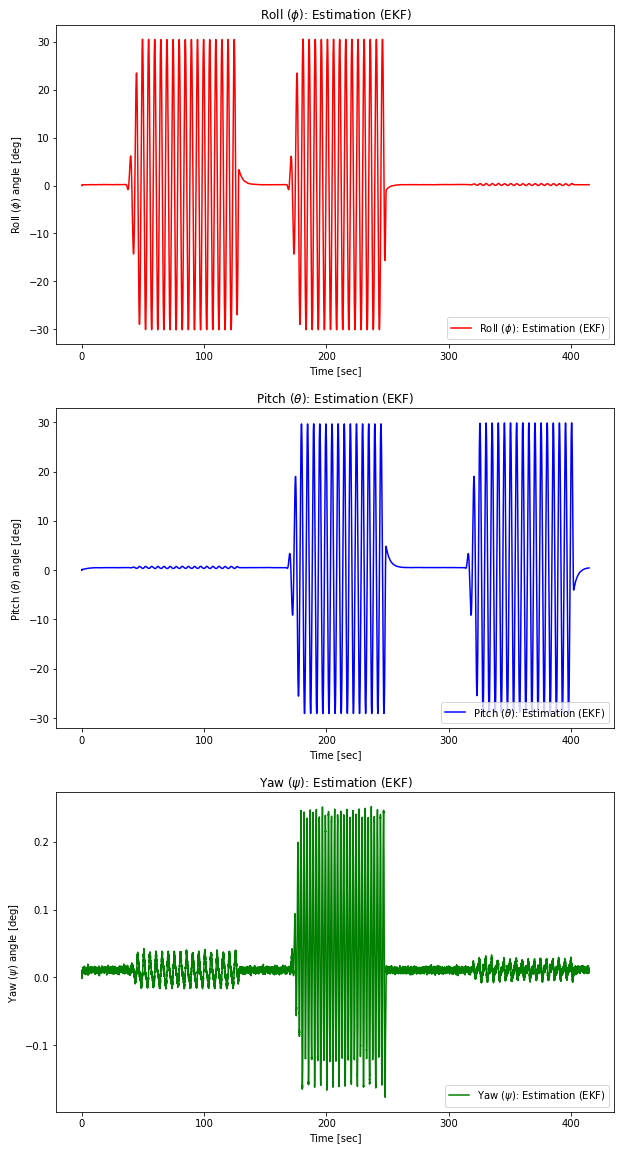

In [14]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 20))

plt.subplot(3, 1, 1)
plt.plot(time, phi_esti_save, 'r', label='Roll ($\\phi$): Estimation (EKF)', markersize=0.2)
plt.legend(loc='lower right')
plt.title('Roll ($\\phi$): Estimation (EKF)')
plt.xlabel('Time [sec]')
plt.ylabel('Roll ($\phi$) angle [deg]')

plt.subplot(3, 1, 2)
plt.plot(time, the_esti_save, 'b', label='Pitch ($\\theta$): Estimation (EKF)', markersize=0.2)
plt.legend(loc='lower right')
plt.title('Pitch ($\\theta$): Estimation (EKF)')
plt.xlabel('Time [sec]')
plt.ylabel('Pitch ($\\theta$) angle [deg]')

plt.subplot(3, 1, 3)
plt.plot(time, psi_esti_save, 'g', label='Yaw ($\\psi$): Estimation (EKF)', markersize=0.2)
plt.legend(loc='lower right')
plt.title('Yaw ($\\psi$): Estimation (EKF)')
plt.xlabel('Time [sec]')
plt.ylabel('Yaw ($\\psi$) angle [deg]')